In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
import sklearn.preprocessing as prep

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)

In [2]:
#import data, remove irrelevant columns
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [3]:
#overview of data
#train.describe(include='all')

In [4]:
#get data correlation
# corrmat = train.corr()
# f, ax = plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat, vmax=.8, square=True);
# plt.show()
# k = 10 #number of variables for heatmap
# cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
# cm = np.corrcoef(train[cols].values.T)
# sns.set(font_scale=1.25)
# hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
# plt.show()

In [5]:
#!jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [6]:
# cols = [x for x in cols if x != 'SalePrice']
# print cols

In [7]:
#create total dataset
train_Y = train['SalePrice']
#train = train[cols]
#test = test[cols]
train = train.loc[:, train.columns != 'SalePrice'] 
df = pd.concat([train,test],axis=0).reset_index(drop=True)

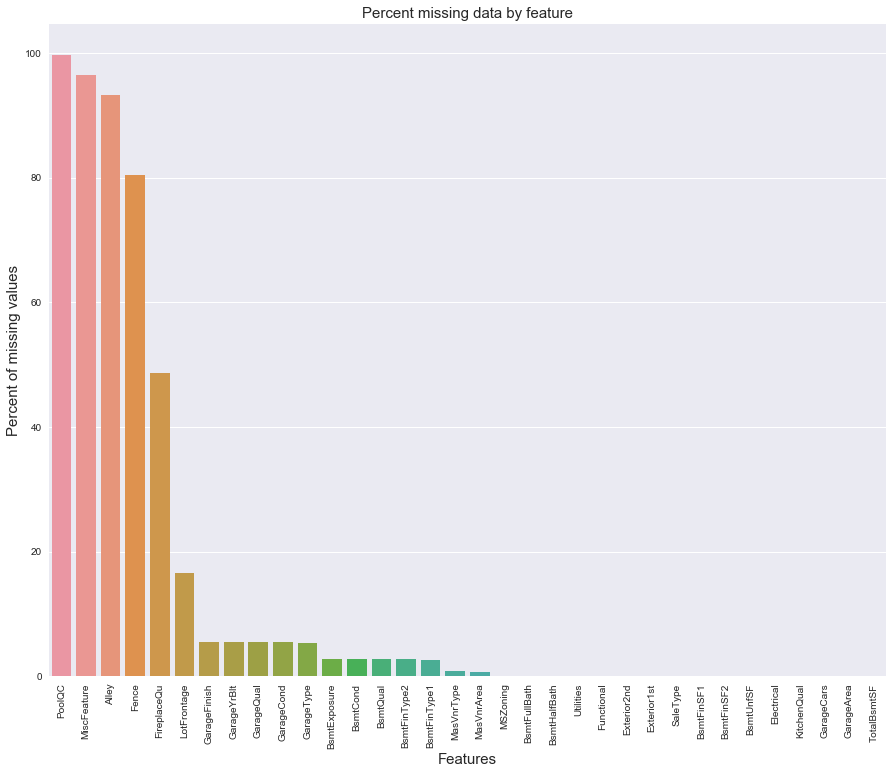

In [8]:
#observe missing values
all_data_na = (df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

In [9]:
################feature Engineering I : fill out missing values#########################

df["PoolQC"] = df["PoolQC"].fillna("None")
df["MiscFeature"] = df["MiscFeature"].fillna("None")
df["Alley"] = df["Alley"].fillna("None")
df["Fence"] = df["Fence"].fillna("None")
df["FireplaceQu"] = df["FireplaceQu"].fillna("None")

df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df[col] = df[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df[col] = df[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df[col] = df[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df[col] = df[col].fillna('None')

df["MasVnrType"] = df["MasVnrType"].fillna("None")
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)

df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])


df = df.drop(['Utilities'], axis=1)

df["Functional"] = df["Functional"].fillna("Typ")


df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])


df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])



df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])


df['MSSubClass'] = df['MSSubClass'].fillna("None")




In [10]:
all_data_na = (df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [806]:
################feature Engineering II : artificial features#########################
df['MSSubClass'] = df['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
df['OverallCond'] = df['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

In [807]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df[c].values)) 
    df[c] = lbl.transform(list(df[c].values))

# shape        
print('Shape all_data: {}'.format(df.shape))




Shape all_data: (2919, 78)


In [808]:
# Adding total sqfootage feature 
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']


In [809]:
# #missing data
# def output_missing_stats(df):
#     total = df.isnull().sum().sort_values(ascending=False)
#     percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
#     tp = df.dtypes
#     missing_data = pd.concat([total, percent,tp], axis=1, keys=['Total', 'Percent','Type'])
#     return missing_data[missing_data['Percent'] > 0.5]
# #drop missing values
# missing_data_to_process = output_missing_stats(df)
# missing_numeric = missing_data_to_process[missing_data_to_process.Type != "object"]
# missing_categorical = missing_data_to_process[missing_data_to_process.Type == "object"]
# #mis_col_drop = missing_data_to_process.index
# #df.drop(df[mis_col_drop],axis=1,inplace=True)
# df[missing_categorical.index] = df[missing_categorical.index].fillna("None")
#fill numeric missing values with median
# df_num = df[numeric_feats]
# df_num = df_num.fillna(df_num.median())
# df[numeric_feats] = df_num

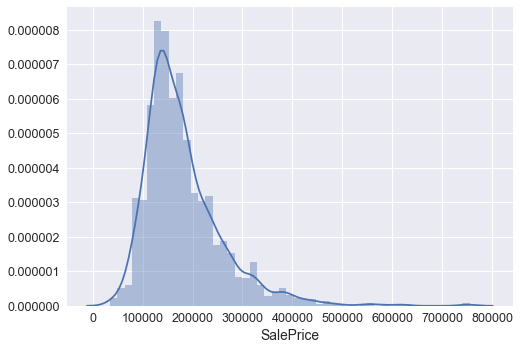

Skewness: 1.882876
Kurtosis: 6.536282


In [810]:
#plot distribution of target variable
sns.distplot(train_Y);
plt.show()
print("Skewness: %f" % train_Y.skew())
print("Kurtosis: %f" % train_Y.kurt())

In [811]:
#log transform skewed data
train_Y = np.log1p(train_Y)
#log transform skewed numeric features:
numeric_feats = df.dtypes[df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df[numeric_feats].apply(lambda x: (x.dropna()).skew()).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.958480
PoolArea,16.907017
LotArea,12.829025
LowQualFinSF,12.094977
3SsnPorch,11.381914
LandSlope,4.977715
KitchenAbvGr,4.304467
BsmtFinSF2,4.148275
EnclosedPorch,4.005950
ScreenPorch,3.948723


In [821]:
skewness = skewness[abs(skewness) > 0.5]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0
for feat in skewed_features:
    #all_data[feat] += 1
    df[feat] = boxcox1p(df[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])


There are 59 skewed numerical features to Box Cox transform


In [822]:
df = pd.get_dummies(df)

In [823]:
train_X = df.iloc[:train.shape[0]]
test_X = df.iloc[train.shape[0]:]

In [824]:
train_X.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,TotalSF,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.939791,1.206856,1.633556,0.457167,0.457167,0.705656,0.0,0.876135,0.766488,1.529364,1.529364,1.326915,0.615725,0.766488,0.615725,0.766488,0.705656,0.615725,1.445025,0.847126,0.0,1.299651,1.461290,0.000000,0.457167,1.461290,1.461094,0.0,1.517120,0.457167,0.000000,0.615725,0.457167,0.705656,0.457167,0.615725,0.900528,0.847126,0.000000,0.705656,1.529364,0.615725,0.615725,1.423105,0.811637,0.811637,0.615725,0.000000,1.199273,0.000000,0.0,0.0,0.0,0.705656,0.766488,0.0,0.766488,0.615725,1.548191,0,0,0,1,0,0,0,0,1,0,0

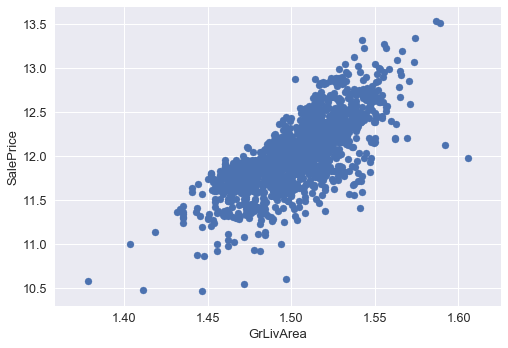

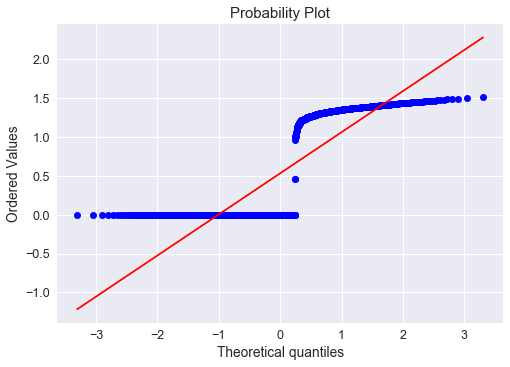

In [825]:
#bivariate investigation
from scipy import stats
fig, ax = plt.subplots()
ax.scatter(x = train_X['GrLivArea'], y =train_Y)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

fig = plt.figure()
res = stats.probplot(train_X.MasVnrArea, plot=plt)
plt.show()

In [533]:
def detect_outliers(df,n,features):
    outlier_indices = []
    # iterate over features(coluns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers   

In [534]:
#get rid of outlier numerical values
outliers_index = detect_outliers(train_X,3,numeric_feats)
train_Y = train_Y.drop(outliers_index,axis = 0)
train_X = train_X.drop(outliers_index,axis = 0)

In [1]:
#build a single model
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_lgb.fit(train_X.values, train_Y.values)
lgb_train_pred = model_lgb.predict(train_X.values)
#lgb_pred = np.exp(lgb_train_pred)-1
print np.sqrt(mean_squared_error(train_Y.values, lgb_train_pred))

NameError: name 'train_X' is not defined

In [827]:

# from sklearn.neural_network import MLPRegressor
# mlp = MLPRegressor(hidden_layer_sizes=(100,100),max_iter=1000,activation = 'relu')
# mlp.fit(train_X.values,train_Y.values)
# mlp_train_pred = mlp.predict(train_X.values)

# print np.sqrt(mean_squared_error(train_Y.values, mlp_train_pred))

In [828]:
# ####################################Method 1 ##################################################

# from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
# from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
# from sklearn.kernel_ridge import KernelRidge
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import RobustScaler
# from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
# from sklearn.model_selection import KFold, cross_val_score, train_test_split
# from sklearn.metrics import mean_squared_error
# import lightgbm as lgb

# n_folds = 5

# def rmsle_cv(model):
#     #kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_X)
#     rmse= np.sqrt(-cross_val_score(model, train_X, train_Y, scoring="neg_mean_squared_error"))
#     return(rmse)

# lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
# ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
# GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
#                                    max_depth=4, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10, 
#                                    loss='huber', random_state =5)
# model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.05, n_estimators=720,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


# class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
#     def __init__(self, base_models, meta_model, n_folds=5):
#         self.base_models = base_models
#         self.meta_model = meta_model
#         self.n_folds = n_folds
   
#     # We again fit the data on clones of the original models
#     def fit(self, X, y):
#         self.base_models_ = [list() for x in self.base_models]
#         self.meta_model_ = clone(self.meta_model)
#         kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
#         # Train cloned base models then create out-of-fold predictions
#         # that are needed to train the cloned meta-model
#         out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
#         for i, model in enumerate(self.base_models):
#             for train_index, holdout_index in kfold.split(X, y):
#                 instance = clone(model)
#                 self.base_models_[i].append(instance)
#                 instance.fit(X[train_index], y[train_index])
                
#                 y_pred = instance.predict(X[holdout_index])
#                 out_of_fold_predictions[holdout_index, i] = y_pred
                
#         # Now train the cloned  meta-model using the out-of-fold predictions as new feature
#         self.meta_model_.fit(out_of_fold_predictions, y)
#         return self
   
#     #Do the predictions of all base models on the test data and use the averaged predictions as 
#     #meta-features for the final prediction which is done by the meta-model
#     def predict(self, X):
#         meta_features = np.column_stack([
#             np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
#             for base_models in self.base_models_ ])
#         return self.meta_model_.predict(meta_features)

# stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost),
#                                                  meta_model = lasso)
# stacked_averaged_models.fit(train_X.values, train_Y.values)
# stacked_train_pred = stacked_averaged_models.predict(train_X.values)
# print np.sqrt(mean_squared_error(train_Y, stacked_train_pred))
# stacked_test_pred = stacked_averaged_models.predict(test_X.values)
# y_pred = stacked_test_pred

# def rmse_cv(model):
#     rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
#     return(rmse)

In [830]:
##############################method 2##########################################3
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.kernel_ridge import KernelRidge
from vecstack import stacking
from sklearn.pipeline import Pipeline

models = [
#     ExtraTreesRegressor(random_state = 0, n_jobs = 2, 
#         n_estimators = 100, max_depth = 3),
    
#     Pipeline([
#       ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
#       ('regression',randomForestRegressor(random_state = 0, n_jobs = 2, 
#         n_estimators = 100, max_depth = 3))
#     ]),
    
#      make_pipeline(SelectFromModel(ExtraTreesRegressor(random_state = 0, n_jobs = 2, n_estimators = 500, max_depth = 3)),RandomForestRegressor(random_state = 0, n_jobs = 2, 
#          n_estimators = 100, max_depth = 3)),
        
    lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=2000,
                              max_bin = 60, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11),
    
    make_pipeline(RobustScaler(), LassoCV(alphas =[0.0005,0.001,0.0015], random_state=1,cv=3)),
    make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)),
    KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),

    GradientBoostingRegressor(n_estimators=2000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5),
    
    ]

# Compute stacking features
S_train, S_test = stacking(models, train_X.values, train_Y.values, test_X.values, 
    regression = True, metric = mean_squared_error, n_folds = 20, 
    shuffle = True, random_state = 0, verbose = 2)


model = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0001, l1_ratio=.9, random_state=3))

#model = RandomForestRegressor(random_state = 0, n_jobs = 2, n_estimators = 1000, max_depth = 3)
    
# Fit 2-nd level model
model = model.fit(S_train, train_Y.values)

# Predict
y_pred = model.predict(S_train)

# Final prediction score
print('Final prediction score: [%.8f]' % mean_squared_error(train_Y.values, y_pred))
y_pred = model.predict(S_test)

task:   [regression]
metric: [mean_squared_error]

model 0: [LGBMRegressor]
    fold 0: [0.01214724]
    fold 1: [0.01368828]
    fold 2: [0.02850356]
    fold 3: [0.01423293]
    fold 4: [0.00935560]
    fold 5: [0.00846297]
    fold 6: [0.01150520]
    fold 7: [0.02170230]
    fold 8: [0.00915352]
    fold 9: [0.01331877]
    fold 10: [0.01545880]
    fold 11: [0.00884441]
    fold 12: [0.02676855]
    fold 13: [0.02431078]
    fold 14: [0.01918514]
    fold 15: [0.02057095]
    fold 16: [0.01173393]
    fold 17: [0.02150558]
    fold 18: [0.01322814]
    fold 19: [0.00735469]
    fold 20: [0.01364190]
    fold 21: [0.00898236]
    fold 22: [0.02605157]
    fold 23: [0.01051465]
    fold 24: [0.01442830]
    fold 25: [0.01631258]
    fold 26: [0.00871109]
    fold 27: [0.00630712]
    fold 28: [0.02144130]
    fold 29: [0.00766255]
    ----
    MEAN:   [0.01484596]

model 1: [Pipeline]
    fold 0: [0.00825352]
    fold 1: [0.01060953]
    fold 2: [0.02663742]
    fold 3: [0.01718153]

In [831]:
#output to test files
test_pred = np.exp(y_pred) - 1
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = test_pred
sub.to_csv('submission.csv',index=False)

In [669]:
def feature_importance(coefficients,name):
    coef = pd.Series(coefficients, index = train_X.columns)
    imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
    imp_coef.plot(kind = "barh")
    title = "Coefficients in the %s Model"%(name)
    plt.title(title)
    plt.show()


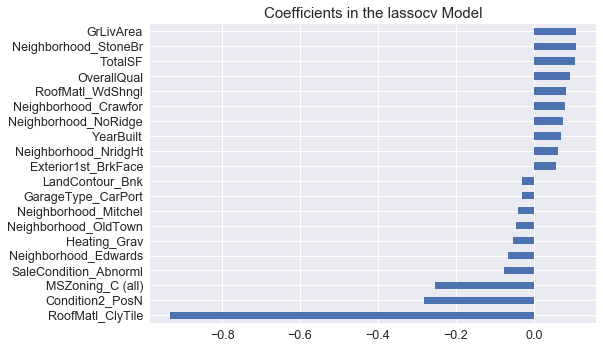

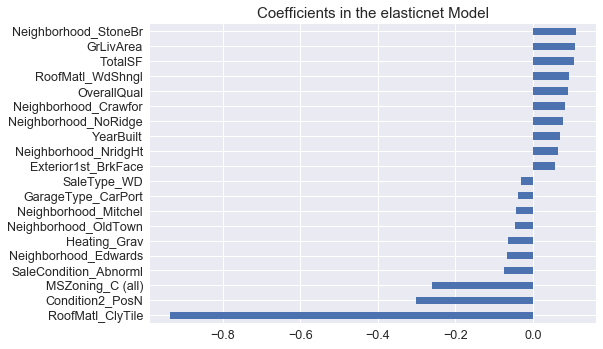

In [729]:
l
#feature_importance(models[1].feature_importances_,"GBM")

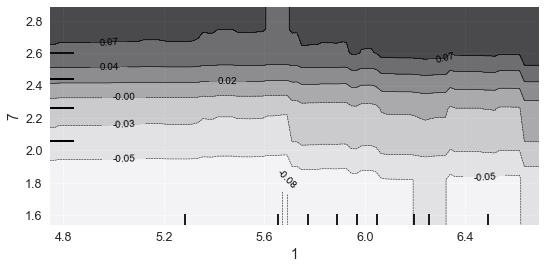

In [672]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
features = [(1,7)]
fig, axs = plot_partial_dependence(models[5], train_X, features) 
plt.show()

In [722]:
?LassoCV

In [752]:
print S_test
y_pred

[[ 11.72283259  11.67331698  11.67426687  11.70577136  11.70257984]
 [ 11.9551114   11.93637614  11.93769459  12.13084852  11.97524013]
 [ 12.13918604  12.11747804  12.11677111  12.1304339   12.14991014]
 ..., 
 [ 12.01634022  12.06499898  12.06455871  11.93396949  11.98674433]
 [ 11.71619787  11.67864078  11.67795914  11.53890899  11.66722033]
 [ 12.31112837  12.32596737  12.32450323  12.31548453  12.27771464]]


array([ 11.69645341,  11.96214501,  12.13434065, ...,  12.01637572,
        11.67642916,  12.30631299])